In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [19]:
# build mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [20]:
import random
random.seed(42)
random.shuffle(words)

In [54]:
# build the dataset
block_size = 8

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            indx = stoi[ch]
            X.append(context)
            Y.append(indx)
            context = context[1:] + [indx]
                
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [55]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [123]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) /fan_in**0.5 # fan_in might not be needed when batch_normalised
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (we will change)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1) # in default batchnorm the 2nd and 3rd dimensions are reverse
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma *xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [124]:
torch.manual_seed(42)

In [125]:
n_embd = 10 # 24
n_hidden = 68 # 128 - better performance but longer time

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight*=0.1
            
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [126]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

AttributeError: 'Embedding' object has no attribute 'out'

In [127]:
model.layers[3].running_mean.shape

torch.Size([68])

In [113]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  1,  2, 18,  9],
        [ 0,  0,  0, 22,  9,  3, 20, 15],
        [ 0,  0,  1, 14,  7,  5, 12,  5],
        [19, 15,  3,  8,  9, 11,  1,  9]])

In [114]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [62]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [63]:
model.layers[1].out.shape

torch.Size([4, 80])

In [64]:
model.layers[2].out.shape

torch.Size([4, 200])

In [66]:
(torch.randn(4, 5, 6, 80) @ torch.randn(80, 200) + torch.randn(200)).shape
# Matrix multiplication applies only to the last dimension

torch.Size([4, 5, 6, 200])

In [67]:
# Now in our waveNet we want only pairs of characters to flatten
# (1, 2) (3, 4) (5, 6) (7, 8)

In [68]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [69]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [70]:
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [71]:
# How to get this [4, 4, 20] from [4, 8, 10]
e = torch.randn(4, 8, 10)
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [72]:
(e.view(4, 4, 20)==explicit).all()

tensor(True)

In [128]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i<150000 else 0.01 # need to adjust accordingly for batch_normalised
    for p in parameters:
        p.data += -lr * p.grad
        
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
#     break

      0/ 200000: 3.3142
  10000/ 200000: 2.2096
  20000/ 200000: 2.1495
  30000/ 200000: 2.1232
  40000/ 200000: 1.9629
  50000/ 200000: 2.4183
  60000/ 200000: 1.9633
  70000/ 200000: 1.8959
  80000/ 200000: 2.1884
  90000/ 200000: 1.8161
 100000/ 200000: 1.5931
 110000/ 200000: 2.3607
 120000/ 200000: 2.3670
 130000/ 200000: 1.9098
 140000/ 200000: 2.2285
 150000/ 200000: 1.7118
 160000/ 200000: 1.8517
 170000/ 200000: 1.9997
 180000/ 200000: 2.1043
 190000/ 200000: 1.6968


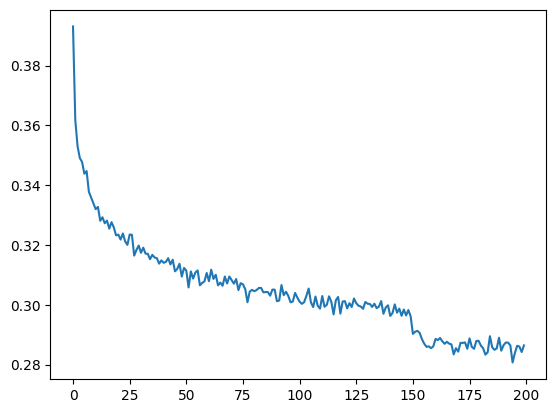

In [129]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [130]:
for layer in model.layers:
    layer.training = False

In [131]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.9110119342803955
val 2.020193099975586


In [132]:

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        indx = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [indx]
        out.append(indx)
        if indx == 0:
            break
            
    print(''.join(itos[i] for i in out))

lansan.
dyluwa.
jenel.
gisen.
fynnton.
nocah.
kamore.
elizan.
audlyn.
cadysin.
kimber.
synnabe.
zhry.
jkeer.
shiito.
noraandro.
aaithel.
quiam.
braeon.
darielli.


In [133]:
# Efficiency by convolution

In [134]:
for x, y in zip(Xtr[7:15], Ytr[7:15]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [135]:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [136]:
logits = torch.zeros(8, 27)
for i in range(8):
    logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [137]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space